 In Lab 5 we cleaned up image and extracted features (pixels values and borders, sort of) from the Sudoku image. Now we want to use the extracted features to recognize the numbers. But this time lets do it with unsupervised learning methods.
 # 1 Recognize the numbers (you can use the MNIST data to train and test the model).
 ## 1.1 MNIST Classification using Multilayer Perceptron (MLP).

In [1]:
#! pip install torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

plt.rcParams['figure.figsize']=(5*1.78,5)
plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']='Georgia'
plt.rcParams['axes.labelsize']=10
plt.rcParams['axes.titlesize']=12

plt.style.use('seaborn-whitegrid')

#cuda = torch.cuda.is_available()
#print("GPU:",cuda)


In [6]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

mnist=fetch_openml('mnist_784', version=1)
X,y= mnist["data"], mnist["target"]
mlp_X_train, mlp_X_test, mlp_y_train, mlp_y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
#Split and normalize train dataset
X_train = pd.DataFrame(mlp_X_train)
y_train = pd.DataFrame(mlp_y_train)

X=X_train.iloc[:,:].values / 255
Y = y_train.iloc[:].values

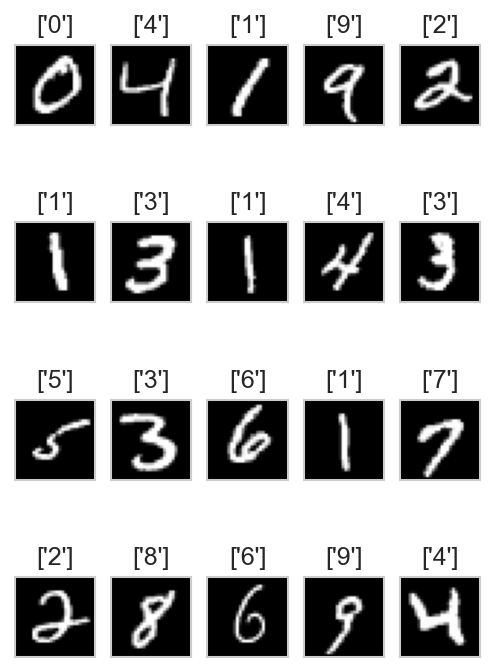

In [8]:
r = 4
c = 5
fig = plt.figure(figsize=(4,6), dpi=150)
for i in range(1, r*c+1):
    img = X[i].reshape((28,28))
    ax = fig.add_subplot(r,c,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(Y[i])
    plt.imshow(img,cmap="gray")
plt.show()

In [15]:
X_train = np.array(mlp_X_train)
X_test = np.array(mlp_X_test)

In [16]:
#Converting our data into a torch object


mlp_X_train = torch.from_numpy(np.asarray(mlp_X_train).astype('float')).type(torch.FloatTensor)
mlp_y_train = torch.from_numpy(np.asarray(mlp_y_train).astype('float')).type(torch.LongTensor)

mlp_X_test = torch.from_numpy(np.asarray(mlp_X_test).astype('float')).type(torch.FloatTensor)
mlp_y_test = torch.from_numpy(np.asarray(mlp_y_test).astype('float')).type(torch.LongTensor)

Validation = pd.read_csv('./validation_images.csv')

In [17]:
mlp_y_validation = Validation['label'].values
mlp_X_validation = Validation.iloc[:,:-1].values / 255

mlp_X_validation = torch.from_numpy(np.asarray(mlp_X_validation).astype('float')).type(torch.FloatTensor)
mlp_y_validation = torch.from_numpy(np.asarray(mlp_y_validation).astype('float')).type(torch.LongTensor)

In [18]:
from torch.utils.data import TensorDataset,DataLoader

train = TensorDataset(mlp_X_train, mlp_y_train)
test = TensorDataset(mlp_X_test, mlp_y_test)

train = DataLoader(train,batch_size=1000)
test = DataLoader(test,batch_size=1000)

validation=TensorDataset(mlp_X_validation,mlp_y_validation)
validation=DataLoader(validation,batch_size=1000)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
        
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X,dim=1)

mlp=Model()
print(mlp)

Model(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [20]:
from torch.optim import Adam
optimizer = Adam(mlp.parameters(),lr=1e-3)

In [21]:
def compute_test_loss(xtest,ytest,model):
    output=model(xtest)
    loss = F.cross_entropy(output,ytest)
    return loss

In [22]:
EPOCHS = 10

train_loss=[]
test_loss=[]
validation_loss=[]

mlp.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train):
        
        optimizer.zero_grad()
        
        y_pred=mlp(data)
        
        loss = F.cross_entropy(y_pred,target)
        train_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_test_loss(X_test,y_test,mlp)
        test_loss.append(loss.cpu().data.item())
        
        loss=compute_test_loss(X_validation, y_validation, mlp)
        validation_loss.append(loss.cpu().data.item())

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [ ]:
plt.plot(train_loss,label='training loss')
plt.plot(test_loss,label='test loss')
plt.plot(validation_loss,label='validation loss')
plt.legend(loc='upper right')

In [ ]:
def predict_with_pytorch(model,val_x):
    
    y_preds=[]
    
    out=model(val_x)
    _, predicted = torch.max(out.data,1)
    
    for p in predicted:
        y_preds.append(p.detach().cpu().numpy().item())
        
    return y_preds

In [ ]:
#Predicting validation set and plotting heatmap

pred=predict_with_pytorch(mlp,X_test)
pred_validation=predict_with_pytorch(mlp,X_validation)

In [ ]:
X_test.numpy()
X_validation.numpy()

In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test.numpy(),pred)
cm_pred=confusion_matrix(y_validation.numpy(),pred_validation)

In [ ]:
names=['Test Confusion Matrix','Validation Confusion Matrix']
images=[cm,cm_pred]

fig, axes = plt.subplots(1,2,figsize=(10,5),dpi=100)

for ax, img, name in zip(axes.ravel(),images,names):
    sns.heatmap(img,annot=True,ax=ax,fmt='d',cmap="Blues")


In [ ]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_test.numpy(),pred)
val_acc = accuracy_score(y_validation.numpy(),pred_validation)

print("Test Accuracy:",test_acc*100,"%")
print("Validation Accuracy:",val_acc*100,"%")

 ## 1.2 MNIST classification using Convolutional neural network(CNN)

In [ ]:
X,y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_test.shape)

CNN_X_train = torch.from_numpy(np.asarray(X_train).astype('float')).type(torch.FloatTensor).view(-1,1,28,28).float()
CNN_y_train = torch.from_numpy(np.asarray(y_train).astype('float')).type(torch.LongTensor)

CNN_X_test = torch.from_numpy(np.asarray(X_test).astype('float')).type(torch.FloatTensor).view(-1,1,28,28).float()
CNN_y_test = torch.from_numpy(np.asarray(y_test).astype('float')).type(torch.LongTensor)

y_validation = Validation['label'].values
X_validation = Validation.iloc[:,:-1].values / 255

CNN_X_validation = torch.from_numpy(np.asarray(X_validation).astype('float')).type(torch.FloatTensor).view(-1,1,28,28).float()
CNN_y_validation = torch.from_numpy(np.asarray(y_validation).astype('float')).type(torch.LongTensor)

In [ ]:
print('CNN_X_train shape:', CNN_X_train.shape)
print('CNN_X_test shape:', CNN_X_test.shape)
print('CNN_y_train shape:', CNN_y_train.shape)
print('CNN_y_test shape:', CNN_y_test.shape)

In [ ]:
from torch.utils.data import TensorDataset,DataLoader
train = TensorDataset(CNN_X_train, CNN_y_train)
test = TensorDataset(CNN_X_test, CNN_y_test)
validation = TensorDataset(CNN_X_validation, CNN_y_validation)

train = DataLoader(train,batch_size=1000)
test = DataLoader(test,batch_size=1000)
validation = DataLoader(validation,batch_size=1000)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = nn.Conv2d(1,16,5)
        self.mxp1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,24,5)
        self.mxp2 = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(24 * 4 * 4, 100)
        self.linear2 = nn.Linear(100,10)
    
    def forward(self,x):
        X=self.mxp1(F.relu(self.conv1(x)))
        X=self.mxp2(F.relu(self.conv2(X)))
        X=X.view(-1,24*4*4)
        X=F.relu(self.linear1(X))
        X=self.linear2(X)
        return F.log_softmax(X, dim=1)

cnn=Model()
print(cnn)

In [ ]:
EPOCHS = 10

train_loss=[]
test_loss=[]
validation_loss=[]

cnn.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train):
        
        optimizer.zero_grad()
        
        y_pred=cnn(data)
        
        loss = F.cross_entropy(y_pred,target)
        train_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_test_loss(CNN_X_test,CNN_y_test,cnn)
        test_loss.append(loss.cpu().data.item())
        
        loss=compute_test_loss(CNN_X_validation, CNN_y_validation, cnn)
        validation_loss.append(loss.cpu().data.item())

    print("Epoch: {} | train_loss: {} | test_loss: {}".format(epoch+1,train_loss[-1],test_loss[-1]))

In [ ]:
plt.plot(train_loss,label='training loss')
plt.plot(test_loss,label='test loss')
plt.plot(validation_loss,label='validation loss')
plt.legend(loc='lower right')

In [ ]:
def predict_with_pytorch(model,val_x):
    
    y_preds=[]
    
    out=model(val_x)
    _, predicted = torch.max(out.data,1)
    
    for p in predicted:
        y_preds.append(p.detach().cpu().numpy().item())
        
    return y_preds

In [ ]:
#Predicting validation set and plotting heatmap

pred=predict_with_pytorch(cnn,CNN_X_test)
pred_validation=predict_with_pytorch(cnn,CNN_X_validation)

In [ ]:
CNN_X_test.numpy()
CNN_X_validation.numpy()

In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(CNN_y_test.numpy(),pred)
cm_pred=confusion_matrix(CNN_y_validation.numpy(),pred_validation)

In [ ]:
names=['Test Confusion Matrix','Validation Confusion Matrix']
images=[cm,cm_pred]

fig, axes = plt.subplots(1,2,figsize=(10,5),dpi=100)

for ax, img, name in zip(axes.ravel(),images,names):
    sns.heatmap(img,annot=True,ax=ax,fmt='d',cmap="Blues")


In [ ]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(CNN_y_test.numpy(),pred)
val_acc = accuracy_score(CNN_y_validation.numpy(),pred_validation)

print("Test Accuracy:",test_acc*100,"%")
print("Validation Accuracy:",val_acc*100,"%")

 ## 1.3 MNIST classification using Recurrent neural network(RNN)

In [ ]:
X,y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_test.shape)

RNN_X_train = torch.from_numpy(np.asarray(X_train).astype('float')).type(torch.FloatTensor).view(-1,28,28).float()
RNN_y_train = torch.from_numpy(np.asarray(y_train).astype('float')).type(torch.LongTensor)

RNN_X_test = torch.from_numpy(np.asarray(X_test).astype('float')).type(torch.FloatTensor).view(-1,28,28).float()
RNN_y_test = torch.from_numpy(np.asarray(y_test).astype('float')).type(torch.LongTensor)

y_validation = Validation['label'].values
X_validation = Validation.iloc[:,:-1].values / 255

RNN_X_validation = torch.from_numpy(np.asarray(X_validation).astype('float')).type(torch.FloatTensor).view(-1,28,28).float()
RNN_y_validation = torch.from_numpy(np.asarray(y_validation).astype('float')).type(torch.LongTensor)

In [ ]:
print('RNN_X_train shape:', RNN_X_train.shape)
print('RNN_X_test shape:', RNN_X_test.shape)
print('RNN_y_train shape:', RNN_y_train.shape)
print('RNN_y_test shape:', RNN_y_test.shape)

In [ ]:
from torch.utils.data import TensorDataset,DataLoader

train = TensorDataset(RNN_X_train, RNN_y_train)
test = TensorDataset(RNN_X_test, RNN_y_test)

train = DataLoader(train,batch_size=1000)
test = DataLoader(test,batch_size=1000)

validation=TensorDataset(RNN_X_validation,RNN_y_validation)
validation=DataLoader(validation,batch_size=1000)

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        self.rnn = nn.LSTM(
            input_size=28,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
        )
        
        self.out = nn.Linear(64,10)
        
    def forward(self,x):
        r_out, (h_n,h_c) = self.rnn(x, None)
        
        out=self.out(r_out[:,-1,:])

        return out

rnn=RNN()
print(rnn)
        

In [ ]:
EPOCHS = 10

train_loss=[]
test_loss=[]
validation_loss=[]

rnn.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train):
        
        optimizer.zero_grad()
        
        y_pred=rnn(data)
        
        loss = F.cross_entropy(y_pred,target)
        train_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_test_loss(RNN_X_test,RNN_y_test,rnn)
        test_loss.append(loss.cpu().data.item())
        
        loss=compute_test_loss(RNN_X_validation, RNN_y_validation, rnn)
        validation_loss.append(loss.cpu().data.item())

    print("Epoch: {} | train_loss: {} | test_loss: {}".format(epoch+1,train_loss[-1],test_loss[-1]))

In [ ]:
plt.plot(train_loss,label='training loss')
plt.plot(test_loss,label='test loss')
plt.plot(validation_loss,label='validation loss')
plt.legend(loc='upper right')

In [ ]:
def predict_with_pytorch(model,val_x):
    
    y_preds=[]
    
    out=model(val_x)
    _, predicted = torch.max(out.data,1)
    
    for p in predicted:
        y_preds.append(p.detach().cpu().numpy().item())
        
    return y_preds

In [ ]:
#Predicting validation set and plotting heatmap

pred=predict_with_pytorch(rnn,RNN_X_test)
pred_validation=predict_with_pytorch(rnn,RNN_X_validation)

In [ ]:
RNN_X_test.numpy()
RNN_X_validation.numpy()

In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(RNN_y_test.numpy(),pred)
cm_pred=confusion_matrix(RNN_y_validation.numpy(),pred_validation)

In [ ]:
names=['Test Confusion Matrix','Validation Confusion Matrix']
images=[cm,cm_pred]

fig, axes = plt.subplots(1,2,figsize=(10,5),dpi=100)

for ax, img, name in zip(axes.ravel(),images,names):
    sns.heatmap(img,annot=True,ax=ax,fmt='d',cmap="Blues")


In [ ]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(RNN_y_test.numpy(),pred)
val_acc = accuracy_score(RNN_y_validation.numpy(),pred_validation)

print("Test Accuracy:",test_acc*100,"%")
print("Validation Accuracy:",val_acc*100,"%")

 # Extra You can Submit it with Lab 8. - Extra Credit lab of the Semester (20 points, optional).
 ## Solve the Sudoku puzzle. Use any Neural Network.